In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

from matplotlib import rcParams

from scipy.optimize import fmin_powell, minimize

In [2]:
rcParams["axes.facecolor"] = "white"
rcParams["figure.facecolor"] = "white"

In [3]:
train_df = pd.read_csv("../data/train.csv", header=0)
test_df = pd.read_csv("../data/test.csv", header=0)

In [69]:
num_classes = 8

In [4]:
nominal = [
    "Product_Info_1", "Product_Info_2", "Product_Info_3", "Product_Info_5", "Product_Info_6", "Product_Info_7",
    "Employment_Info_2", "Employment_Info_3", "Employment_Info_5",
    "InsuredInfo_1", "InsuredInfo_2", "InsuredInfo_3", "InsuredInfo_4", "InsuredInfo_5", "InsuredInfo_6", "InsuredInfo_7",
    "Insurance_History_1", "Insurance_History_2", "Insurance_History_3", "Insurance_History_4", "Insurance_History_7", "Insurance_History_8", "Insurance_History_9",
    "Family_Hist_1",
    "Medical_History_2", "Medical_History_3", "Medical_History_4", "Medical_History_5", "Medical_History_6", "Medical_History_7",
    "Medical_History_8", "Medical_History_9", "Medical_History_11", "Medical_History_12", "Medical_History_13", "Medical_History_14",
    "Medical_History_16", "Medical_History_17", "Medical_History_18", "Medical_History_19", "Medical_History_20", "Medical_History_21",
    "Medical_History_22", "Medical_History_23", "Medical_History_25", "Medical_History_26", "Medical_History_27", "Medical_History_28",
    "Medical_History_29", "Medical_History_30", "Medical_History_31", "Medical_History_33", "Medical_History_34", "Medical_History_35",
    "Medical_History_36", "Medical_History_37", "Medical_History_38", "Medical_History_39", "Medical_History_40", "Medical_History_41",
]
continuous = [
    "Product_Info_4", 
    "Ins_Age", "Ht", "Wt", "BMI",
    "Employment_Info_1", "Employment_Info_4", "Employment_Info_6",
    "Insurance_History_5",
    "Family_Hist_2", "Family_Hist_3", "Family_Hist_4", "Family_Hist_5",
]
discrete = ["Medical_History_1", "Medical_History_10", "Medical_History_15", "Medical_History_24", "Medical_History_32"]
dummy = ["Medical_Keyword_{}".format(x) for x in range(1, 49)]

In [5]:
def quadratic_kappa(actuals, preds, N=5):
    """This function calculates the Quadratic Kappa Metric used for Evaluation in the PetFinder competition
    at Kaggle. It returns the Quadratic Weighted Kappa metric score between the actual and the predicted values 
    of adoption rating."""    
    w = np.zeros((N,N))
    O = confusion_matrix(actuals, preds)
    for i in range(len(w)): 
        for j in range(len(w)):
            w[i][j] = float(((i-j)**2)/(N-1)**2)
    
    act_hist=np.zeros([N])
    for item in actuals: 
        try:
            act_hist[item]+=1
        except IndexError:
            print(item)
    
    pred_hist=np.zeros([N])
    for item in preds: 
        pred_hist[item]+=1
                         
    E = np.outer(act_hist, pred_hist);
    E = E/E.sum();
    O = O/O.sum();
    
    num=0
    den=0
    for i in range(len(w)):
        for j in range(len(w)):
            num+=w[i][j]*O[i][j]
            den+=w[i][j]*E[i][j]
    
    return 1 - (num/den)

In [6]:
len(train_df.index), len(test_df.index)

(59381, 19765)

The training set has 59381 samples while the test set has 19765 samples.

In [7]:
sns.set_style("whitegrid")

In [228]:
all_data = pd.concat((train_df, test_df), axis=0, ignore_index=True).copy()
f = OneHotEncoder(sparse=False).fit_transform(all_data[["Product_Info_2"]].values)
f = pd.concat((
    all_data[["Id", "Response"]], 
#     pd.DataFrame(f, columns=["Product_Info_2_{}".format(x) for x in range(f.shape[1])]),
#     all_data[[x for x in nominal if x != "Product_Info_2"] + continuous + discrete],
    all_data[nominal + continuous + discrete],
    all_data[[x for x in nominal if "Medical_History" in x and "_2" not in x]].sum(axis=1).rename("Medical_History_Sum"),
    all_data[[x for x in dummy if x.startswith("Medical_Keyword")]],
    all_data[dummy].sum(axis=1).rename("Medical_Keyword_Count"),
), axis=1).fillna(-999)
f["BMI_Age"] = f["BMI"] * f["Ins_Age"]
f["BMI_MKC"] = f["BMI"] * np.sqrt(f["Medical_Keyword_Count"])
f['Product_Info_2_char'] = f.Product_Info_2.str[0]
f['Product_Info_2_num'] = f.Product_Info_2.str[1]
f['Product_Info_2'] = pd.factorize(f['Product_Info_2'])[0]
f['Product_Info_2_char'] = pd.factorize(f['Product_Info_2_char'])[0]
f['Product_Info_2_num'] = pd.factorize(f['Product_Info_2_num'])[0]

tmp_ = all_data[[x for x in all_data.columns if x.startswith("Medical_History") and x in nominal and not x.endswith("_2")]].reset_index().copy()
tmp_ = pd.melt(tmp_, id_vars="index")
# tmp_[tmp_.index == 0]
tmp_ = tmp_.groupby(["index", "value"]).size().reset_index()
tmp_ = pd.pivot(tmp_, "index", "value", 0)
tmp_.columns = ["Medical_History_Count{}".format(i) for i in tmp_.columns]
tmp_.columns.name = ""
f = pd.concat((f, tmp_.fillna(-999)), axis=1)
# f["Response"] -= 1
f

,Id,Response,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_5,Product_Info_6,Product_Info_7,Employment_Info_2,Employment_Info_3,...,Medical_Keyword_47,Medical_Keyword_48,Medical_Keyword_Count,BMI_Age,BMI_MKC,Product_Info_2_char,Product_Info_2_num,Medical_History_Count1,Medical_History_Count2,Medical_History_Count3
0,2,8.0,1,0,10,2,1,1,12,1,...,0,0,0,0.207304,0.000000,0,0,11,9,15
1,5,4.0,1,1,26,2,3,1,1,3,...,0,0,0,0.016256,0.000000,1,1,13,9,13
2,6,8.0,1,2,26,2,3,1,9,1,...,0,0,0,0.012799,0.000000,2,1,9,12,14
3,7,8.0,1,3,10,2,3,1,9,1,...,0,0,1,0.057863,0.352438,0,2,9,12,14
4,8,8.0,1,4,26,2,3,1,9,1,...,0,0,0,0.177213,0.000000,0,3,9,12,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79141,79093,-999.0,1,0,26,2,3,1,9,1,...,0,0,0,0.153096,0.000000,0,0,10,11,14
79142,79099,-999.0,1,3,10,2,3,1,14,1,...,0,0,0,0.059959,0.000000,0,2,9,11,15
79143,79102,-999.0,1,6,26,2,3,1,1,3,...,0,0,3,0.558067,1.136179,1,3,11,8,16
79144,79125,-999.0,1,7,26,2,3,1,14,1,...,0,0,0,0.427678,0.000000,0,1,10,11,14


In [116]:
def xgb_qkappa_wrapper(preds, actuals_dm):
    actuals = actuals_dm.get_label().astype(int) - 1
    preds = np.clip(np.round(preds), 0, 7).astype(int)
    return "qkappa", quadratic_kappa(actuals, preds, 8)

In [178]:
np.array([1, 0, 1, 1]).reshape(2, 2).astype(int).argmax(axis=0)

array([0, 1])

In [188]:
def eval_wrapper(yhat, y):  
    y = np.array(y) - 1
    y = y.astype(int)
    
    yhat = np.array(yhat) - 1
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return quadratic_kappa(y, yhat, 8)

def score_offset(data, bin_offset, sv, scorer=eval_wrapper):
    # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
    data[1, data[0].astype(int)==sv] = data[0, data[0].astype(int)==sv] + bin_offset
    score = scorer(data[1], data[2])
    return score
    
def apply_offsets(data, offsets):
    for j in range(num_classes):
        data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j]
    return data

def score_offset_mv(data, offsets, scorer=eval_wrapper):
    # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
    data[1] = np.vstack([ (data[0] < ofs) for ofs in offsets ] + [np.ones_like(data[0]).astype(bool)]).argmax(axis=0) + 1
#     print(data[:2])
    return scorer(data[1], data[2])

def apply_offsets_mv(data, offsets):
    data[1] = np.vstack([ (data[0] < ofs) for ofs in offsets ] + [np.ones_like(data[0]).astype(bool)]).argmax(axis=0) + 1
    return data

# def score_offset_mv(data, offsets, scorer=eval_wrapper):
#     # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
#     data[1] = data[0] + np.take(offsets, np.clip(data[0].astype(int)-1, 0, 7))
#     score = scorer(data[1], data[2])
#     return score
    
# def apply_offsets_mv(data, offsets):
#     data[1] = data[0] + np.take(offsets, np.clip(data[0].astype(int)-1, 0, 7))
#     return data

In [231]:
xgb_rank_params1 = dict(
    booster="gbtree",
    eta=.03,
    objective='reg:squarederror',
    max_depth=8,
    subsample=.9,
    colsample_bytree=0.5,
    min_child_weight=320
)

train_ind = f.index[f["Response"] > 0]
test_ind = f.index[f["Response"] < 0]

train_dm = xgb.DMatrix( f.loc[train_ind].drop(columns=["Id", "Response"]), label=f.loc[train_ind, "Response"].values, missing=-999 )
test_dm = xgb.DMatrix( f.loc[test_ind].drop(columns=["Id", "Response"]), label=f.loc[test_ind, "Response"].values, missing=-999 )

eval_list  = [ (train_dm,'train') ]

rank_model = xgb.train(
    xgb_rank_params1, 
    train_dm, 
    num_boost_round=720, 
    evals=eval_list,
    verbose_eval=False,
    feval=xgb_qkappa_wrapper,
    maximize=True
)

train_preds = rank_model.predict(train_dm, ntree_limit=rank_model.best_iteration)
print("Last training score: {}".format( eval_wrapper(train_preds, f.loc[train_ind, "Response"].values) ))
test_preds = rank_model.predict(test_dm, ntree_limit=rank_model.best_iteration)

offsets = np.ones(7) * 1.3
offset_preds = np.vstack((train_preds, train_preds, f.loc[train_ind, 'Response'].values))
offset_res = minimize(lambda x: -score_offset_mv(offset_preds, x), offsets, method="Powell")

# train_preds_tuned = apply_offsets_mv(offset_preds, offset_res.x).clip(1, 8).astype(int)[1]
# test_preds_tuned = apply_offsets_mv(np.vstack((test_preds, test_preds)), offset_res.x).round().clip(1, 8).astype(int)[1]
train_preds_tuned = apply_offsets_mv(offset_preds, offset_res.x)[1].astype(int)
test_preds_tuned = apply_offsets_mv(np.vstack((test_preds, test_preds)), offset_res.x)[1].astype(int)

print("Last training score (tuned): {}".format(eval_wrapper(train_preds_tuned, f.loc[train_ind, "Response"].values)))

pd.concat((test_df["Id"], pd.Series(test_preds_tuned, name="Response")), axis=1).to_csv("../output/test_preds.csv", index=False)

Last training score: 0.6546026790707433
Last training score (tuned): 0.7076269206342599


In [261]:
# xgb_rank_params_cv = dict(
#     booster="gbtree",
#     eta=[.05, .1, .5],
#     objective='reg:squarederror',
#     max_depth=[3, 5, 7],
#     subsample=[.5, .7, .9],
#     colsample_bytree=0.5,
#     min_child_weight=[200, 320]
# )

rank_model_cv = xgb.cv(
    xgb_rank_params1, 
    train_dm, 
    num_boost_round=300, 
    nfold=5,
#     verbose_eval=False,
    feval=xgb_qkappa_wrapper,
    maximize=True
)

In [264]:
rank_model_cv

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-qkappa-mean,train-qkappa-std,test-qkappa-mean,test-qkappa-std
0,5.547265,0.006248,5.547429,0.025209,0.000000,0.000000,0.000000,0.000000
1,5.404512,0.006414,5.404908,0.024387,0.000000,0.000000,0.000000,0.000000
2,5.266607,0.005723,5.267381,0.024610,0.000000,0.000000,0.000000,0.000000
3,5.132946,0.004835,5.134026,0.024912,0.000000,0.000000,0.000000,0.000000
4,5.004009,0.004825,5.005264,0.024462,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
295,1.789089,0.004542,1.848478,0.013013,0.542177,0.002257,0.518724,0.006594
296,1.788816,0.004557,1.848367,0.012978,0.542395,0.002299,0.518831,0.006478
297,1.788504,0.004574,1.848277,0.013003,0.542515,0.002252,0.518859,0.006414
298,1.788338,0.004583,1.848234,0.013016,0.542521,0.002227,0.518835,0.006341


(array([ 4460.,  4361.,  4439.,     0.,  4337.,  7567.,     0.,  7380.,
         8374., 18463.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <BarContainer object of 10 artists>)

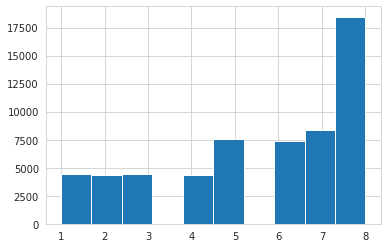

In [230]:
plt.hist(train_preds_tuned)

In [94]:
offsets = np.array([0.1, -1, -2, -1, -0.8, 0.02, 0.8, 1])
offset_preds = np.vstack((train_preds, train_preds, f.loc[train_ind, 'Response'].values))
offset_res = minimize(lambda x: -score_offset_mv(offset_preds, x), offsets, method="Powell")
print(offset_res)
train_preds_tuned = apply_offsets_mv(offset_preds, offset_res.x).clip(1, 8).astype(int)[1]
test_preds_tuned = apply_offsets_mv(np.vstack((test_preds, test_preds)), offset_res.x).round().clip(1, 8).astype(int)[1]

   direc: array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])
     fun: -0.6615557367554008
 message: 'Optimization terminated successfully.'
    nfev: 391
     nit: 3
  status: 0
 success: True
       x: array([-3.09885615, -1.97075097, -1.23310193, -0.88031859, -0.03848075,
        0.74101156,  8.56378688,  8.76378688])


In [71]:
offsets = np.array([0.1, -1, -2, -1, -0.8, 0.02, 0.8, 1])
offset_preds = np.vstack((train_preds, train_preds, f.loc[train_ind, 'Response'].values))
offset_preds = apply_offsets(offset_preds, offsets)
opt_order = [6,4,5,3]
for j in opt_order:
    train_offset = lambda x: -score_offset(offset_preds, x, j) * 100
    offsets[j] = fmin_powell(train_offset, offsets[j], disp=False)
test_preds_tuned = apply_offsets(np.vstack((test_preds, test_preds)), offsets).round().clip(1, 8).astype(int)[1]

In [95]:
pd.concat((test_df["Id"], pd.Series(test_preds_tuned, name="Response")), axis=1).to_csv("../output/test_preds.csv", index=False)

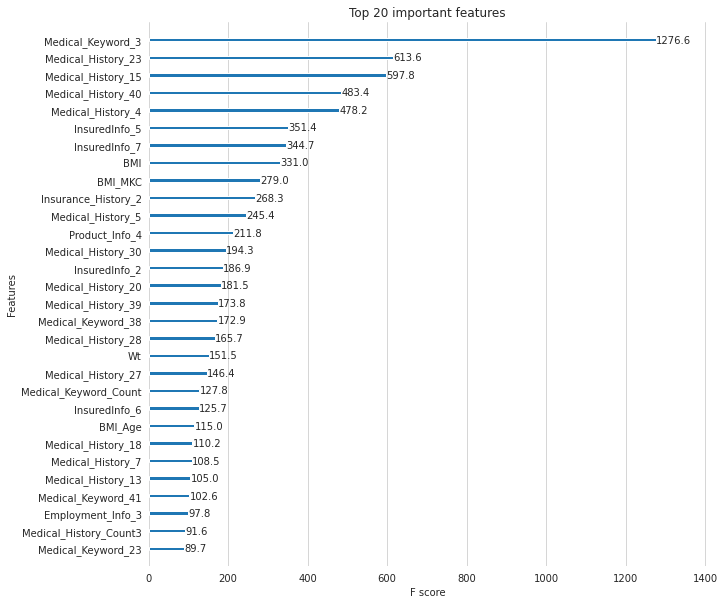

In [245]:
plt.figure(figsize=(10, 10))
g = xgb.plot_importance(rank_model, ax=plt.gca(), importance_type="gain", max_num_features=30, title="Top 20 important features")
sns.despine(g.get_figure(), left=True, bottom=True)
plt.grid(False, axis="y")

for lbl_ in (x for x in g.get_children() if "Text" in str(x.__class__) and x.get_text().replace(".", "").isnumeric()):
    lbl_.set_text("{:.1f}".format( round(float(lbl_.get_text()), 1) ))

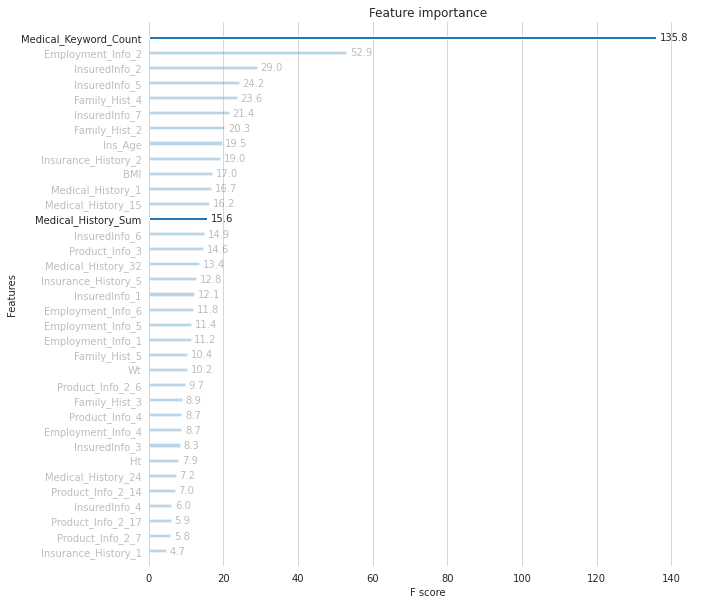

In [293]:
plt.figure(figsize=(10, 10))
g = xgb.plot_importance(rank_model, ax=plt.gca(), importance_type="gain")
sns.despine(g.get_figure(), left=True, bottom=True)
plt.grid(False, axis="y")

for lbl_ in (x for x in g.get_children() if "Text" in str(x.__class__) and x.get_text().replace(".", "").isnumeric()):
    lbl_.set_text("{:.1f}".format( round(float(lbl_.get_text()), 1) ))
    
for rect_ in ( x for i, x in enumerate(g.get_children())
              if "Rectangle" in str(x.__class__) and i not in [22, 34]
                 or "Text" in str(x.__class__) and x.get_text().replace(".", "").isnumeric() and i not in [57, 69]):
    rect_.set_alpha(.3)

for lbl_ in (x for x in g.get_yaxis().get_ticklabels() if x.get_text() not in ["Medical_Keyword_Count", "Medical_History_Sum"]):
    lbl_.set_alpha(.3)

In [98]:
all_data[all_data['Response']<1]

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response,Product_Info_2_char,Product_Info_2_num,BMI_Age,Med_Keywords_Count
0,1,1,0,26,0.487179,2,3,1,0.611940,0.781818,...,0,0,0,0,0,-1000,0,0,0.288996,3
1,3,1,6,26,0.076923,2,3,1,0.626866,0.727273,...,0,0,0,0,0,-1000,1,3,0.304020,0
2,4,1,0,26,0.144667,2,3,1,0.582090,0.709091,...,0,0,0,0,0,-1000,0,0,0.302165,3
3,9,1,1,26,0.151709,2,1,1,0.522388,0.654545,...,0,0,0,1,1,-1000,1,1,0.254383,3
4,12,1,1,26,0.076923,2,3,1,0.298507,0.672727,...,0,0,0,0,0,-1000,1,1,0.127976,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19760,79093,1,0,26,0.128205,2,3,1,0.537313,0.636364,...,0,0,0,0,0,-1000,0,0,0.153096,0
19761,79099,1,3,10,0.230769,2,3,1,0.134328,0.618182,...,0,0,0,0,0,-1000,0,2,0.059959,0
19762,79102,1,6,26,0.076923,2,3,1,0.850746,0.727273,...,0,0,0,0,0,-1000,1,3,0.558067,3
19763,79125,1,7,26,0.487179,2,3,1,0.522388,0.745455,...,0,0,0,0,0,-1000,0,1,0.427678,0


In [100]:
def get_params():
    params = {}
    params["objective"] = "reg:squarederror"     
    params["eta"] = .01
    params["min_child_weight"] = 360
    params["subsample"] = 0.85
    params["colsample_bytree"] = 0.3
    params["silent"] = 1
    params["max_depth"] = 7
    plst = list(params.items())

    return plst

# global variables
columns_to_drop = ['Id', 'Response'] #, 'Medical_History_10','Medical_History_24']
xgb_num_rounds = 720
num_classes = 8
missing_indicator = -1000

# combine train and test
all_data = train_df.append(test_df)

# Found at https://www.kaggle.com/marcellonegro/prudential-life-insurance-assessment/xgb-offset0501/run/137585/code
# create any new variables    
all_data['Product_Info_2_char'] = all_data.Product_Info_2.str[0]
all_data['Product_Info_2_num'] = all_data.Product_Info_2.str[1]

# factorize categorical variables
all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]

all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']

med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)

all_data["BMI_MKC"] = all_data["BMI"] * np.sqrt(all_data["Med_Keywords_Count"])

print('Eliminate missing values')    
all_data.fillna(missing_indicator, inplace=True)

# fix the dtype on the label column
all_data['Response'] = all_data['Response'].astype(int)

# split train and test
train = all_data[all_data['Response']>0].copy()
test = all_data[all_data['Response']<1].copy()

# convert data to xgb data structure
xgtrain = xgb.DMatrix(train.drop(columns_to_drop, axis=1), train['Response'].values, 
                        missing=missing_indicator)
xgtest = xgb.DMatrix(test.drop(columns_to_drop, axis=1), label=test['Response'].values, 
                        missing=missing_indicator)    

# get the parameters for xgboost
plst = get_params()
print(plst)      

# train model
model = xgb.train(plst, xgtrain, xgb_num_rounds) 

# get preds
train_preds = model.predict(xgtrain, ntree_limit=model.best_iteration)
print('Train score is:', eval_wrapper(train_preds, train['Response'])) 
test_preds = model.predict(xgtest, ntree_limit=model.best_iteration)

# train offsets 
offsets = np.array([0.1, -1, -2, -1, -0.8, 0.02, 0.8, 1])
offset_preds = np.vstack((train_preds, train_preds, f.loc[train_ind, 'Response'].values))
offset_res = minimize(lambda x: -score_offset_mv(offset_preds, x), offsets, method="Powell")
print(offset_res)
train_preds_tuned = apply_offsets_mv(offset_preds, offset_res.x).clip(1, 8).astype(int)[1]
test_preds_tuned = apply_offsets_mv(np.vstack((test_preds, test_preds)), offset_res.x).round().clip(1, 8).astype(int)[1]
print('Offset Train score is:', eval_wrapper(train_preds_tuned, train['Response'])) 

preds_out = pd.DataFrame({"Id": test['Id'].values, "Response": test_preds_tuned})
preds_out = preds_out.set_index('Id')
preds_out.to_csv('../output/xgb_offset_submission.csv')

Eliminate missing values
[('objective', 'reg:squarederror'), ('eta', 0.1), ('min_child_weight', 360), ('subsample', 0.85), ('colsample_bytree', 0.5), ('silent', 1), ('max_depth', 7)]
[14:45:19] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train score is: 0.6939724506396505
   direc: array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])
     fun: -0.7443741465592277
 message: 'Optimization terminated successfully.'
    nfev: 246
     nit: 2
  status: 0

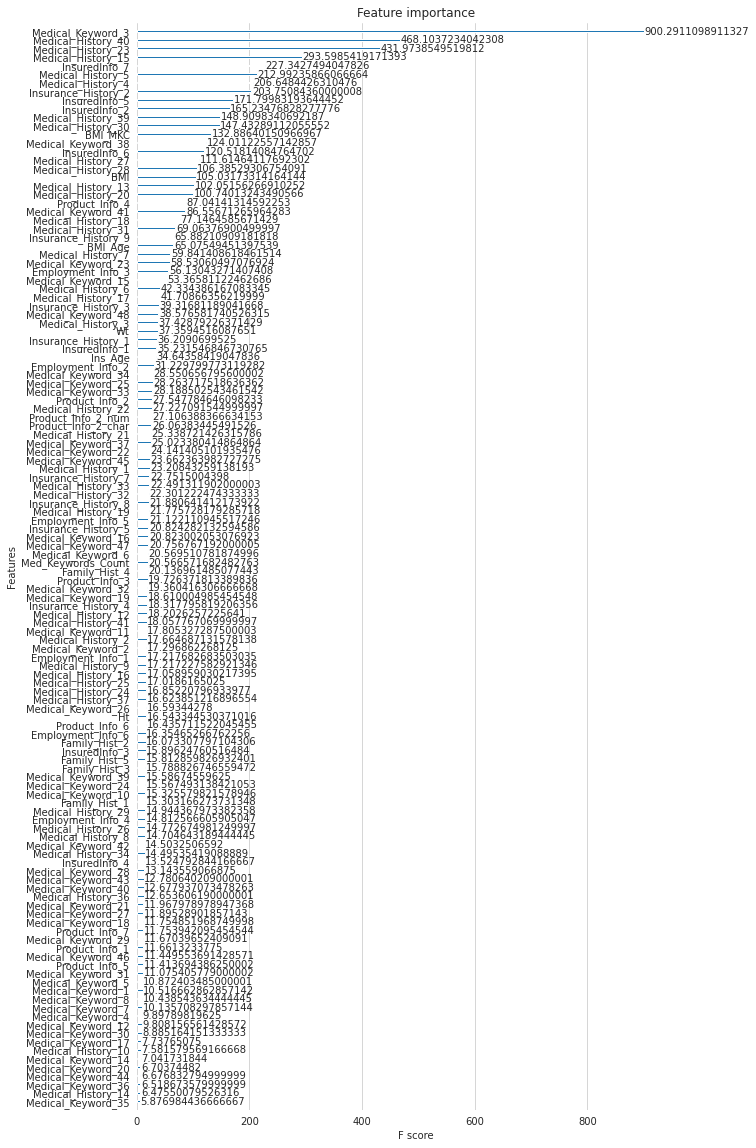

In [102]:
plt.figure(figsize=(10, 20))
g = xgb.plot_importance(model, ax=plt.gca(), importance_type="gain")
sns.despine(g.get_figure(), left=True, bottom=True)
plt.grid(False, axis="y")